In [1]:
from lstm_models import LSTM
from gpu_dataloader import ForecastDataset, UtilizationDataset
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# plotting the data
import matplotlib.pyplot as plt
# used for the dataframes
import pandas as pd
from tqdm import tqdm

import random

from utils import get_device
from loss_classes import RMSELoss

import numpy as np
%matplotlib inline

from utils import get_device_as_string, get_device

/Users/macbook/opt/miniconda3/envs/ml_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math

def get_rmse(actual_values, predicted_values) -> float:
    '''returns the root mean squared error'''
    return math.sqrt(mean_squared_error(actual_values, predicted_values))


def get_mape(actual_values, predicted_values):
    '''returns the mean absolue percentage error'''
    return np.mean(np.abs(actual_values - predicted_values) / np.abs(actual_values) * 100)


def get_mae(actual_values, predicted_values) -> float:
    '''returns the mean absolute error'''
    return mean_absolute_error(actual_values, predicted_values)

In [3]:
batch_size: int = 1000
dataset = UtilizationDataset(small_df=True, batch_size=batch_size)

In [4]:
dataset.X.size()

torch.Size([2000, 1, 18])

In [5]:
num_epochs: int = 50
learning_rate: float = 1e-3

# number of features
input_size: int = dataset.X.shape[2]
# number of features in hidden state
hidden_size: int = dataset.X.shape[2] * 32
# number of stacked lstm layers
num_layers: int = 1
# number of output classes
num_classes: int = dataset.y.shape[1]

device = get_device()

INCLUDE_WANDB: bool = False

In [6]:
if INCLUDE_WANDB == True:
    import wandb
    wandb.init(project='Hardware Utilization Prediction')

    wandb.config.num_epochs = num_epochs
    wandb.config.learning_rate = learning_rate
    wandb.config.input_size = input_size
    wandb.config.hidden_size = hidden_size
    wandb.config.num_layers = num_layers
    wandb.config.num_classes = num_classes

In [7]:
LOSS: str = 'loss'
RMSE_TRAINING: str = 'root mean squared error (training)'
MAE_TRAINING: str = 'mean absolute error (training)'

if INCLUDE_WANDB:
    wandb.define_metric(LOSS, summary='min')
    wandb.define_metric(RMSE_TRAINING, summary='min')
    wandb.define_metric(MAE_TRAINING, summary='min')

In [8]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dataset.X.shape[1])
lstm.train()

# log gradients and model parameters
if INCLUDE_WANDB:
    wandb.watch(lstm)

lstm

LSTM(
  (init_linear): Linear(in_features=18, out_features=18, bias=True)
  (lstm): LSTM(18, 576, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc_1): Linear(in_features=1152, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=4, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [9]:
# mean square error for regression
# criterion = nn.MSELoss()
# criterion = criterion.to(get_device())
criterion = RMSELoss()
criterion = criterion.to(device)
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08)


In [10]:
def log_training_metrics(predictions, labels, loss):
    # logging to wandb
    if get_device_as_string() == 'cuda' or get_device_as_string() == 'mps':
        o = predictions.cpu().detach().numpy()
        l = labels.cpu().detach().numpy()
    else:
        o = predictions.detach().numpy()
        l = labels.detach().numpy()
    rmse = get_rmse(o, l)
    mae = get_mae(o, l)
    log_dict: dict = {
        LOSS: loss.item(),
        RMSE_TRAINING: rmse,
        MAE_TRAINING: mae,
    }
    wandb.log(log_dict)
    # print(log_dict)

In [11]:
# def reorder_dataset(dataset: ForecastDataset, batch_size: int):
#     batch_order = np.array([batch for batch in range(0, len(dataset), batch_size)], dtype=np.int32)
#     batch_order = np.random.permutation(batch_order)

#     dataset_order = np.empty(shape=[0, len(dataset.X)], dtype=np.int32)

#     for batch in batch_order:
#         if batch >= len(dataset) - (batch_size - 1):
#             continue
#         filled_batch_order = np.arange(batch, batch + batch_size, dtype=np.int32)
#         dataset_order = np.append(dataset_order, filled_batch_order)
        
#     dataset.X = dataset.X[dataset_order]
#     dataset.y = dataset.y[dataset_order]

In [17]:
test_set = UtilizationDataset(is_training=False, small_df=True, batch_size=batch_size)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

loss_val = None
for epoch in (pbar := tqdm(range(0, num_epochs), desc=f'Training Loop -- Loss: {loss_val}')):

    # if epoch % 10 == 0:
        # reorder_dataset(dataset, batch_size)
        # train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    for _, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)


        predictions = lstm(inputs).to(device)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        
    if INCLUDE_WANDB:
        log_training_metrics(predictions, labels, loss)
    loss_val = loss.item()
    pbar.set_description(f'Training Loop -- Loss: {loss_val:.3f}')
    
    with torch.no_grad():
        val_pred = lstm(test_set.X.to(device))
        val_loss = criterion(val_pred, test_set.y.to(device))
        scheduler.step(val_loss)
        


Training Loop -- Loss: 0.10912103950977325: 100%|██████████| 50/50 [01:48<00:00,  2.18s/it]


In [ ]:
import time

current_time = time.ctime()
current_time

'Fri Oct 14 15:01:08 2022'

## Save the Model to Disk

In [ ]:
lstm.eval()
model_name = f'models/epochs-{num_epochs}-{current_time}'

torch.save(
    {
        'epoch': num_epochs,
        'learning_rate': learning_rate,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'model_state_dict': lstm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },
    f'{model_name}'
)

In [29]:
X_df = dataset.X
X_df = X_df.to(device)
# forward pass
prediction = lstm(X_df)
# prediction = prediction.reshape(1, -1)
if torch.has_cuda or torch.has_mps:
    prediction = prediction.detach().numpy()
    
else:
    prediction = prediction.data.numpy()


actual_data = dataset.y.data

# reverse transformation

label_columns = dataset._get_label_columns()
# prediction = dataset.y_scaler.inverse_normalization_df(pd.DataFrame(prediction, columns=label_columns))
# prediction = dataset.minmax_scaler.inverse_transform(prediction)
# actual_data = dataset.minmax_scaler.inverse_transform(actual_data)

# create dataframes
prediction_df = pd.DataFrame(prediction, columns=label_columns)
actual_data_df = pd.DataFrame(actual_data, columns=label_columns)
prediction_df = dataset.y_scaler.inverse_normalization_df(prediction_df)
actual_data_df = dataset.y_scaler.inverse_normalization_df(actual_data_df)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## Calculate Root Mean Squared Error

Calculating the RMSE for the overall prediction of the (training) dataset.

In [20]:
rmse_key: str = 'Root Mean Squared Error (Overall - Training)'
rmse_result = get_rmse(actual_data_df[:], prediction_df[:])
print(f'Test Score: {rmse_result:.2f} RMSE')
if INCLUDE_WANDB:
    wandb.summary[rmse_key] = rmse_result

Test Score: 46356.11 RMSE


## Calculate Mean Absolute Error

Calcutlate the MAE for the overall prediction of the (training) dataset.

In [21]:
mae_key: str = 'Mean Absolute Error (Overall - Training)'
mae_result = mean_absolute_error(actual_data_df[:], prediction_df[:])
print(f'Test Score: {mae_result} MAE')

if INCLUDE_WANDB:
    wandb.summary[mae_key] = mae_result

Test Score: 16511.07839857423 MAE


In [22]:
def plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number: int = 0, rmse_threshold: float = 0.30, is_training: bool = True):

    if len(label_columns) <= column_number:
        print('Out of Prediction Bounds')
        return

    plt.figure(figsize=(25, 15))  # plotting
    plt.rcParams.update({'font.size': 22})

    column = label_columns[column_number]
    pred_column = f"pred_{column}_{'training' if is_training else 'test'}"

    rmse = get_rmse(actual_values[column], predicted_values[column])
    mae = mean_absolute_error(actual_values[column], predicted_values[column])

    predicted_color = 'green' if rmse < rmse_threshold else 'orange'

    plt.plot(actual_values[column], label=column, color='black')  # actual plot
    plt.plot(predicted_values[column], label='pred_' +
             column, color=predicted_color)  # predicted plot

    plt.title('Time-Series Prediction')
    plt.plot([], [], ' ', label=f'RMSE: {rmse}')
    plt.plot([], [], ' ', label=f'MAE: {mae}')
    plt.legend()
    plt.ylabel('timeline', fontsize=25)
    
    if INCLUDE_WANDB:
        wandb.log({pred_column: wandb.Image(plt)})
        wandb.summary[f'Root Mean Squared Error ({column})'] = rmse
        wandb.summary[f'Mean Absolute Error ({column})'] = mae
        
    plt.show()


## See Predictions on Training Dataset

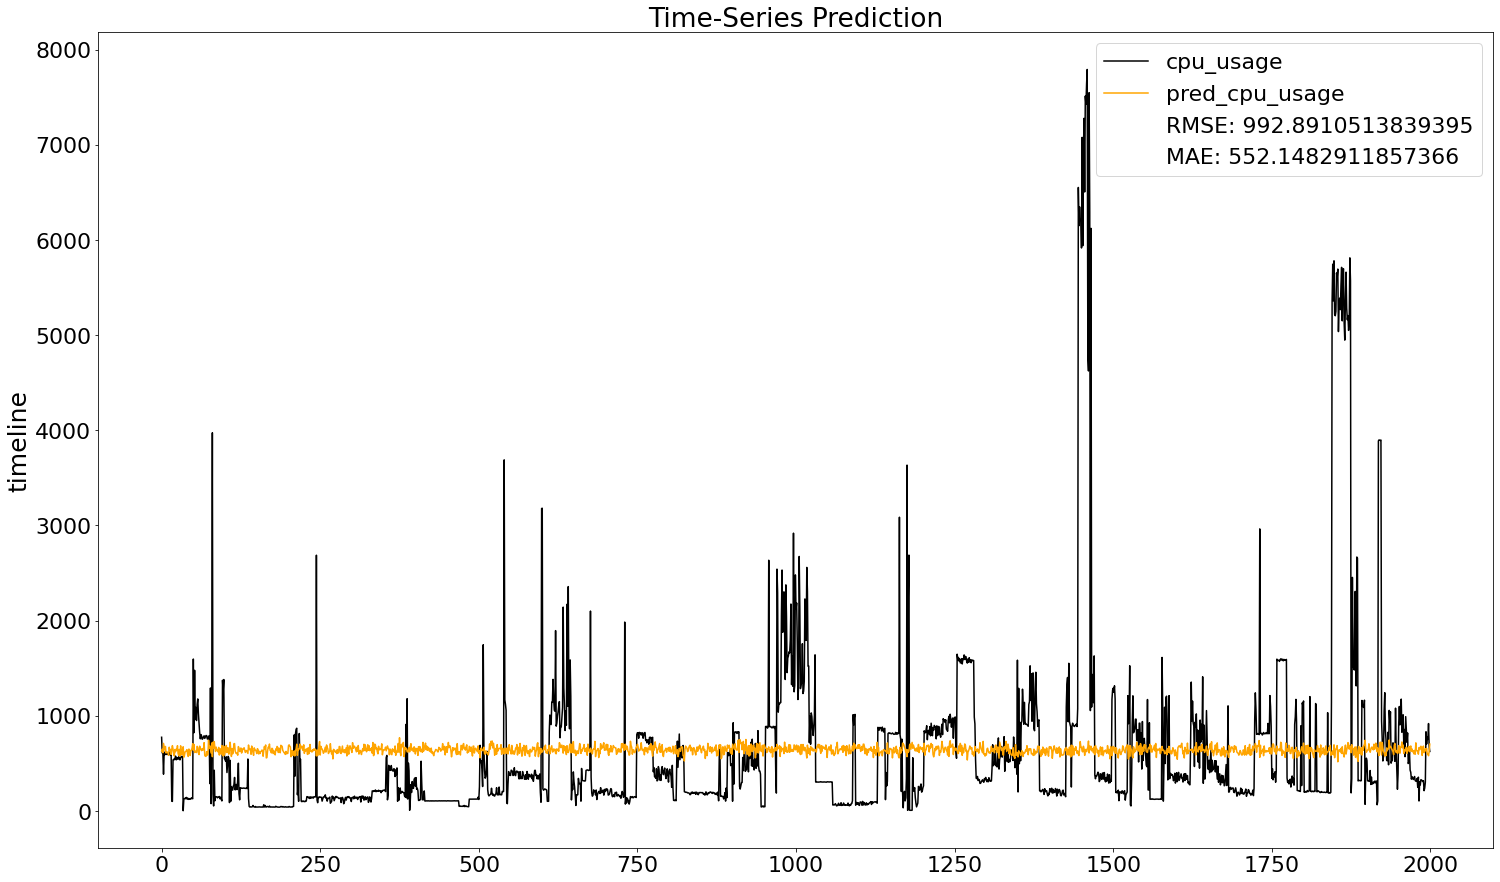

In [23]:
plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number=0)

In [ ]:
# plot_column(actual_values=actual_data_df[7000:8000], predicted_values=prediction_df[7000:8000], column_number=0)

## Test Set Analysis

Below, the test set will be loaded and the model evaluated with it to see the actual performance.

In [ ]:
# test_dataset = GPUDataset(is_training=False, small_df=True, batch_size=batch_size)

In [ ]:
lstm.eval()

X_df = test_set.X
X_df = X_df.to(device)
# forward pass
prediction = lstm(X_df)
if get_device_as_string() == 'cuda' or get_device_as_string() == 'mps':
    prediction = prediction.cpu().data.numpy()
else:
    prediction = prediction.data.numpy()
# prediction = test_set.standard_scaler.fit_transform(prediction)

actual_data = test_set.y.data.numpy()
actual_data = test_set.minmax_scaler.fit_transform(actual_data)

# reverse transformation
prediction = test_set.minmax_scaler.inverse_transform(prediction)
actual_data = test_set.minmax_scaler.inverse_transform(actual_data)

label_columns = test_set._get_label_columns()
# create dataframes
prediction_df = pd.DataFrame(prediction, columns=label_columns)
actual_data_df = pd.DataFrame(actual_data, columns=label_columns)


AttributeError: 'UtilizationDataset' object has no attribute 'minmax_scaler'

In [ ]:
rmse_key: str = 'Root Mean Squared Error (Overall - Test)'
rmse_result = get_rmse(actual_data_df[:], prediction_df[:])
print(f'Test Score: {rmse_result:.2f} RMSE')

if INCLUDE_WANDB:
    wandb.summary[rmse_key] = rmse_result

Test Score: 29721.80 RMSE


In [ ]:
mae_key: str = 'Mean Absolute Error (Overall - Test)'
mae_result = mean_absolute_error(actual_data_df[:], prediction_df[:])
print(f'Test Score: {mae_result} MAE')
if INCLUDE_WANDB:
    wandb.summary[mae_key] = mae_result

Test Score: 14921.4716796875 MAE


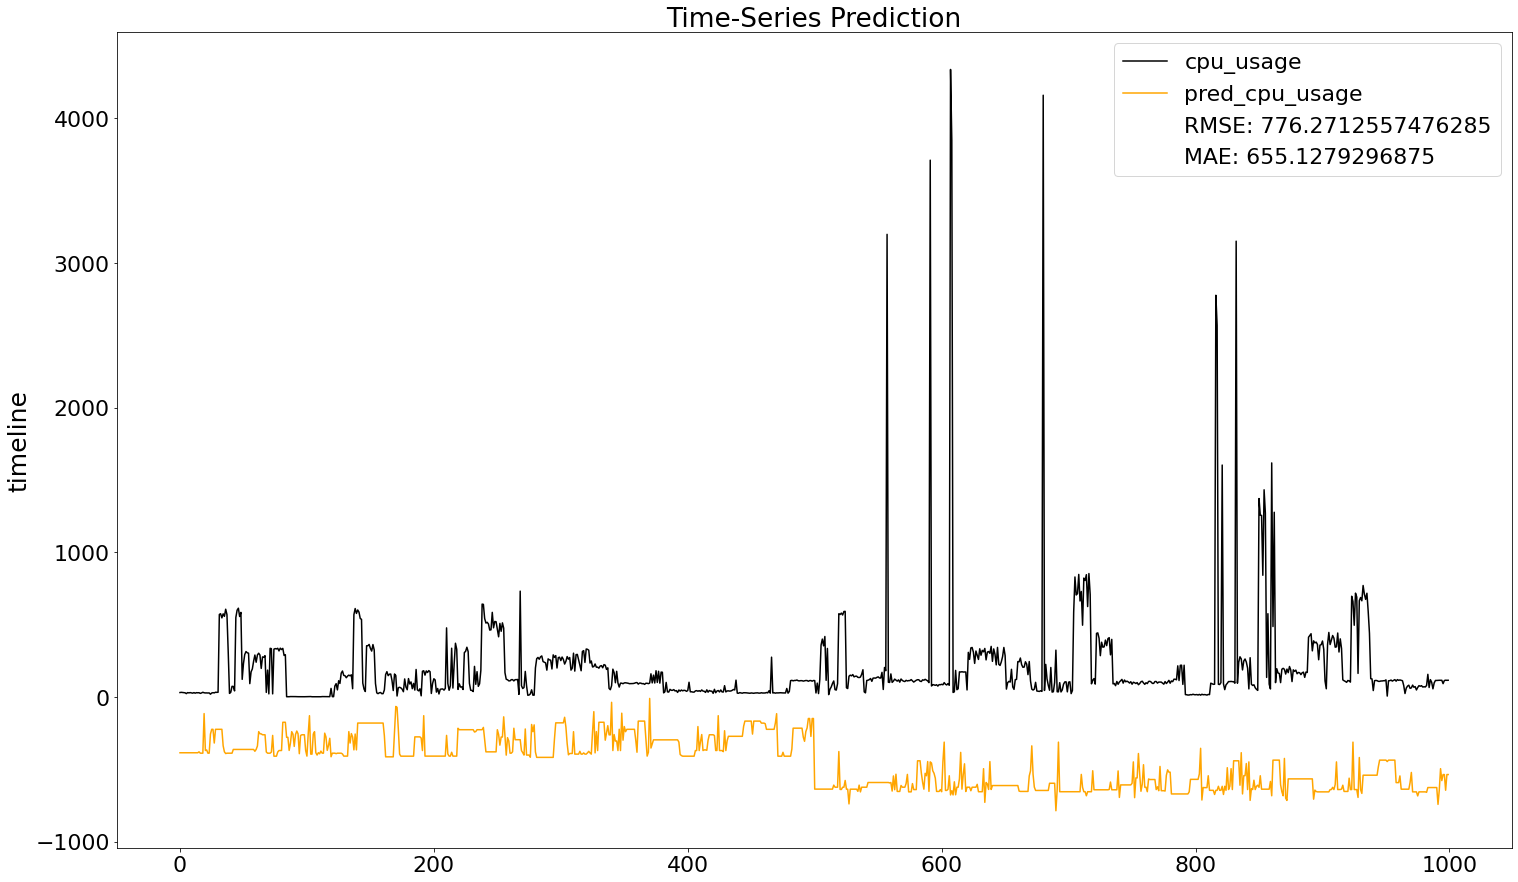

In [ ]:
plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number=0)

In [ ]:
# start_idx, end_idx = 9000, 10000
# plot_column(actual_values=actual_data_df[start_idx:end_idx], predicted_values=prediction_df[start_idx:end_idx], column_number=0)